In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy 

import textwrap

import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../../../..')
# print(root_path)
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))

from sklearn.model_selection import train_test_split
from causaltune import CausalTune
from causaltune.data_utils import CausalityDataset
from causaltune.datasets import generate_synthetic_data

# Import linear synthetic data creation
from causaltune.datasets import generate_linear_synthetic_data

In [2]:
# set a few params
metrics = [
    "frobenius_norm",
    #"prob_erupt",
    "policy_risk",
    #"codec",
    #"energy_distance", 
    "psw_energy_distance"
    ]
    
n_samples = 1000
test_size = 0.33 # equal train,val,test
#time_budget = 21600
components_time_budget = 600

estimator_list = [
             #"Dummy",
             "SparseLinearDML",
             "ForestDRLearner",
             "TransformedOutcome",
             "CausalForestDML",
             ".LinearDML",
             "DomainAdaptationLearner",
             #"SLearner",
             "XLearner",
             #"TLearner",
             #"Ortho"        
    ] 

n_runs = 1
out_dir = ""
filename_out = "non_linear_600" 

# 1. Dataset Generation

In [3]:
# Create empty dictionary
data_sets = {}

### 1.1 Non-linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [4]:
#cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
#cd_non_linear.preprocess_dataset()
#data_sets['rct_non-linear'] = cd_non_linear

In [5]:
cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
cd_non_linear.preprocess_dataset()
data_sets['known_confounders_non-linear'] = cd_non_linear

In [6]:
#cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
#cd_non_linear.preprocess_dataset()
#data_sets['IV_non-linear'] = cd_non_linear
#cd_linear.data.head(5)

### 1.2 Linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [7]:
#cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
#cd_linear.preprocess_dataset()
#data_sets['Unknown_Confounders_linear'] = cd_linear

In [8]:
#cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
#cd_linear.preprocess_dataset()
#data_sets['Known_Confounders_linear'] = cd_linear

In [9]:
#cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
#cd_linear.preprocess_dataset()
#data_sets['IV_linear'] = cd_linear
#cd_linear.data.head(5)

# 2. Model Fitting

In [11]:
import time

run_times = {}

start_time = time.time()

for dataset_name, cd in data_sets.items():
    print("----------------- DATA SET: ",dataset_name)
    
    for i_run in range(1,n_runs+1):
        
        cd_i = copy.deepcopy(cd)
        train_df, test_df = train_test_split(cd_i.data, test_size=test_size)
        test_df = test_df.reset_index(drop=True)
        cd_i.data = train_df
        
        for metric in metrics:

            print("___________________________________________________________________________")
            print("EVALUATING: ", metric)
    
            start_time_metric = time.time()
            
            ct = CausalTune(
                metric=metric,
                metrics_to_report = [metric],
                verbose=1,
                components_verbose=1,
                components_time_budget=components_time_budget,
                estimator_list=estimator_list,
                store_all_estimators=True,
            )

            ct.fit(
                data=cd_i,
                treatment="treatment",
                outcome="outcome",
            )

            # compute relevant scores (skip newdummy)
            datasets = {"train": ct.train_df, "validation": ct.test_df, "test": test_df}
            # get scores on train,val,test for each trial, 
            # sort trials by validation set performance
            # assign trials to estimators
            estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}
            for trial in ct.results.trials:
                # estimator name:
                estimator_name = trial.last_result["estimator_name"]
                if  trial.last_result["estimator"]:
                    estimator = trial.last_result["estimator"]
                    scores = {}
                    for ds_name, df in datasets.items():
                        scores[ds_name] = {}
                        # make scores
                        est_scores = ct.scorer.make_scores(
                            estimator,
                            df,
                            metrics_to_report=ct.metrics_to_report,
                        )

                        # add cate:
                        scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                        # add ground truth for convenience
                        scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                        scores[ds_name][metric] = est_scores[metric]
                    estimator_scores[estimator_name].append(scores)


            # sort trials by validation performance
            for k in estimator_scores.keys():
                estimator_scores[k] = sorted(
                    estimator_scores[k],
                    key=lambda x: x["validation"][metric],
                    reverse=False if metric in ["energy_distance", "psw_energy_distance", "codec"] else True,
                )

            end_time_metric = time.time()
            compute_time_metric = end_time_metric - start_time_metric
    
            print(f"COMPUTE TIME METRIC: {compute_time_metric} seconds")

            run_times[metric]=compute_time_metric

            results = {
                "best_estimator": ct.best_estimator,
                "best_config": ct.best_config,
                "best_score": ct.best_score,
                "optimised_metric": metric,
                "scores_per_estimator": estimator_scores,
                "run_time": compute_time_metric
            }

            with open(f"{out_dir}{filename_out}_{metric}_run_{i_run}_{dataset_name}.pkl", "wb") as f:
                pickle.dump(results, f)
            
            print("DONE WITH METRIC...")
    
            print("___________________________________________________________________________")


end_time = time.time()
total_time = end_time - start_time
print("TOTAL RUNTIME: ",total_time)



[flaml.tune.tune: 07-23 10:30:37] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-23 10:30:37] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}


----------------- DATA SET:  known_confounders_non-linear
___________________________________________________________________________
EVALUATING:  frobenius_norm
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': True, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_int

[flaml.tune.tune: 07-23 11:10:37] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-23 11:40:38] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 07-23 12:00:38] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': 1, 'mc_agg': 'mean'}}
[flaml.tune.tune: 07-23 12:20:38] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': 1, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 9.999999999999999e-05, 'max_iter': 10000, 'mc_agg': 'mean'}}
[flaml.tu

COMPUTE TIME METRIC: 10801.991112709045 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  prob_erupt


[flaml.tune.tune: 07-23 13:30:39] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-23 13:30:39] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': True, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': True, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 0.0001, 'max_iter': 10000, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.Ca

[flaml.tune.tune: 07-23 14:10:41] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-23 14:40:43] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 07-23 15:00:45] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': 1, 'mc_agg': 'mean'}}
[flaml.tune.tune: 07-23 15:20:46] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': 1, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 9.999999999999999e-05, 'max_iter': 10000, 'mc_agg': 'mean'}}
[flaml.tu

COMPUTE TIME METRIC: 10832.447434186935 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  policy_risk


[flaml.tune.tune: 07-23 16:31:12] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-23 16:31:12] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': True, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': True, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 0.0001, 'max_iter': 10000, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.Ca

[flaml.tune.tune: 07-23 17:11:13] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-23 17:41:13] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 07-23 18:01:13] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': 1, 'mc_agg': 'mean'}}
[flaml.tune.tune: 07-23 18:21:14] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': 1, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 9.999999999999999e-05, 'max_iter': 10000, 'mc_agg': 'mean'}}
[flaml.tu

COMPUTE TIME METRIC: 10802.969867229462 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  codec
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': True, 'mc_agg': 'mean'}}, {'estima

[flaml.tune.tune: 07-23 20:11:15] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-23 20:41:15] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 07-23 21:01:16] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': 1, 'mc_agg': 'mean'}}
[flaml.tune.tune: 07-23 21:21:16] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': 1, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 9.999999999999999e-05, 'max_iter': 10000, 'mc_agg': 'mean'}}
[flaml.tu

COMPUTE TIME METRIC: 10803.341236114502 seconds
DONE WITH METRIC...
___________________________________________________________________________
___________________________________________________________________________
EVALUATING:  psw_energy_distance
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': True, 'mc_agg': 'mea

[flaml.tune.tune: 07-23 23:11:19] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-23 23:41:20] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 07-24 00:01:20] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': 1, 'mc_agg': 'mean'}}
[flaml.tune.tune: 07-24 00:21:20] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': 1, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 9.999999999999999e-05, 'max_iter': 10000, 'mc_agg': 'mean'}}
[flaml.tu

COMPUTE TIME METRIC: 10803.503586053848 seconds
DONE WITH METRIC...
___________________________________________________________________________
TOTAL RUNTIME:  54044.28101301193


In [35]:
import matplotlib.pyplot as plt
import pickle
import textwrap
import numpy as np

# Define list of experiments and metrics
# trials = ['rct_non-linear', 'known_confounders_non-linear', 'IV_non-linear', 
#           'rct_linear', 'known_confounders_linear','IV_linear']

trials = ['known_confounders_non-linear', 'known_confounders_linear']

metrics = ['psw_energy_distance', 'frobenius_norm', 'policy_risk']#,  'prob_erupt','codec', ]

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(25, 25), dpi=300)

# Flatten axs for easier indexing
axs = axs.flatten()

# Plot true against estimated for best estimator
for i, (trial, metric) in enumerate([(t, m) for t in trials for m in metrics]):

    ax = axs[i]
    
    # Load results
    # if "non-" in trial:
    #     filename = f"psw_relevant_600_{metric}_run_1_{trial}.pkl"
    # else:
    #     filename = f"linear_600_{metric}_run_1_{trial}.pkl"

    filename = f"psw_relevant_600_{metric}_run_1_{trial}.pkl"

    with open(filename, "rb") as f:
        results = pickle.load(f)

    #filename = f"non_linear_600_{metric}_run_1_{trial}.pkl"
    print(filename)
    with open(filename, "rb") as f:
        results = pickle.load(f)
    
    best_estimator = results["best_estimator"]
    CATE_gt = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_groundtruth"]
    CATE_est = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_estimate"]
    
    # Plot
    ax.scatter(CATE_gt, CATE_est, s=20, alpha=0.1)
    ax.plot([min(CATE_gt), max(CATE_gt)], [min(CATE_gt), max(CATE_gt)], "k-", linewidth=0.5)
    
    ax.set_xlabel("True CATE")
    ax.set_ylabel("Estimated CATE")
    
    # Wrap the title text
    title_text = f"{metric}\n({trial})"
    wrapped_title = "\n".join(textwrap.wrap(title_text, width=20))
    ax.set_title(wrapped_title)
    
    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Add correlation coefficient

    cate_gt_for_cor = list(CATE_gt)
    try:
        cate_est_for_cor = CATE_est[:,0]
    except:
        cate_est_for_cor = CATE_est

    corr = np.corrcoef(cate_gt_for_cor, cate_est_for_cor)[0, 1]
    ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes, 
            verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.savefig("all_metrics_comparison.pdf", format="pdf")
plt.show()

psw_relevant_600_psw_energy_distance_run_1_known_confounders_non-linear.pkl
psw_relevant_600_frobenius_norm_run_1_known_confounders_non-linear.pkl
psw_relevant_600_policy_risk_run_1_known_confounders_non-linear.pkl
psw_relevant_600_psw_energy_distance_run_1_known_confounders_linear.pkl
psw_relevant_600_frobenius_norm_run_1_known_confounders_linear.pkl
psw_relevant_600_policy_risk_run_1_known_confounders_linear.pkl


backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.LinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dr.ForestDRLearner: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.S

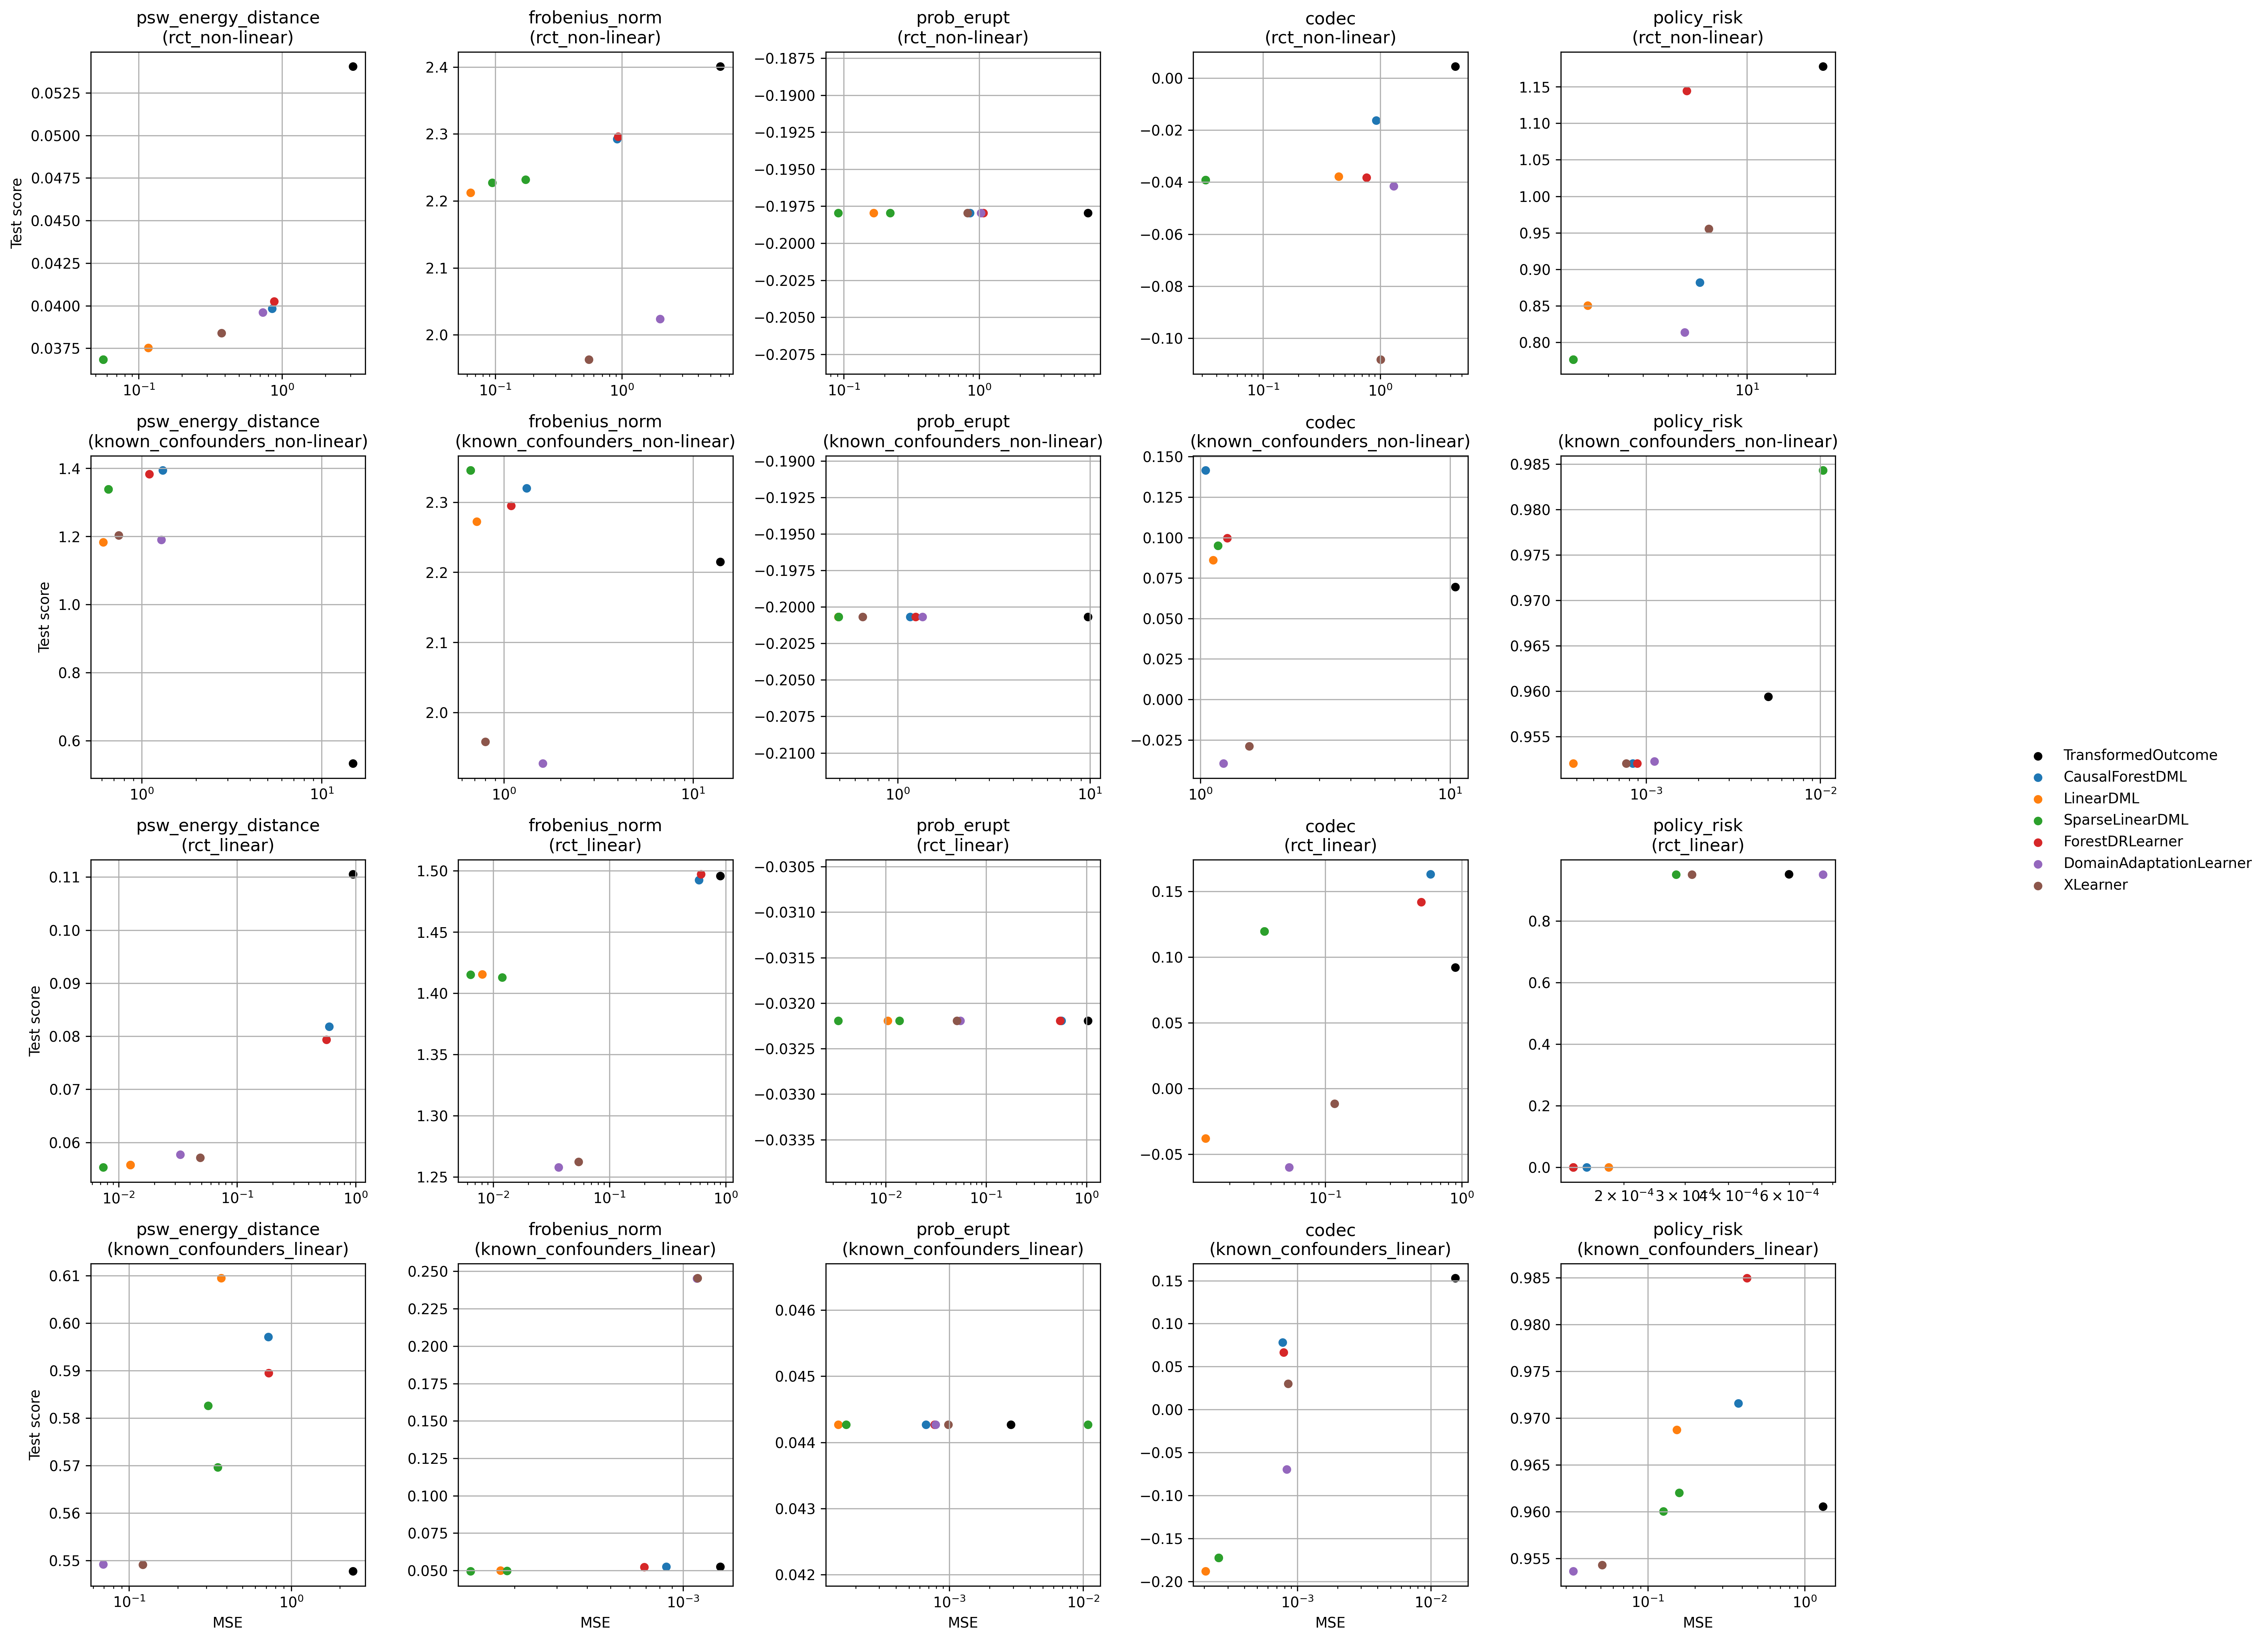

In [33]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle

import colorsys

def scale_lightness(rgb, scale_l):
    # found here https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

# Define list of experiments and metrics
trials = ['rct_non-linear', 'known_confounders_non-linear','rct_linear', 'known_confounders_linear']
metrics = ['psw_energy_distance', 'frobenius_norm', 'prob_erupt','codec', 'policy_risk' ]

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
          list(matplotlib.colors.TABLEAU_COLORS) + [
              matplotlib.colors.CSS4_COLORS['lime'],
              matplotlib.colors.CSS4_COLORS['yellow'],
              matplotlib.colors.CSS4_COLORS['pink']
          ])

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

fig, axs = plt.subplots(len(trials), len(metrics), figsize=(len(metrics)*4, len(trials)*4), dpi=300)

for row, trial in enumerate(trials):
    est_labels = [[] for _ in range(len(metrics))]
    for col, metric in enumerate(metrics):
        ax = axs[row, col]
        if "non-" in trial:
            filename = f"non_linear_600_{metric}_run_1_{trial}.pkl"
        else:
            filename = f"linear_600_{metric}_run_1_{trial}.pkl"
        with open(filename, "rb") as f:
            results = pickle.load(f)
        
        for idx, (est_name, scr) in enumerate(results["scores_per_estimator"].items()):
            if "Dummy" not in est_name:
                if len(scr):
                    # Plot intermediate runs
                    if len(scr) > 1:
                        print(f"{est_name}: {len(scr)} intermediate runs ")
                        lightness = np.linspace(1, 2.8, len(scr))
                        col_rgb = matplotlib.colors.ColorConverter.to_rgb(colors[idx])
                        for i_run in range(1, len(scr)):
                            CATE_gt = scr[i_run]["test"]["CATE_groundtruth"]
                            CATE_est = scr[i_run]["test"]["CATE_estimate"]
                            CATE_gt = np.array(CATE_gt).flatten()
                            CATE_est = np.array(CATE_est).flatten()
                            mse = np.mean((CATE_gt - CATE_est)**2)
                            score = scr[i_run]["test"][metric]
                            ax.scatter(mse, score, color=scale_lightness(col_rgb, lightness[i_run-1]), s=30, linewidths=0.5, label="_nolegend_")
                    
                    # Plot best estimator
                    CATE_gt = scr[0]["test"]["CATE_groundtruth"]
                    CATE_est = scr[0]["test"]["CATE_estimate"]
                    CATE_gt = np.array(CATE_gt).flatten()
                    CATE_est = np.array(CATE_est).flatten()
                    mse = np.mean((CATE_gt - CATE_est)**2)
                    score = scr[0]["test"][metric]
                    ax.scatter(mse, score, color=colors[idx], s=30, linewidths=0.5)
                    est_labels[col].append(est_name.split(".")[-1])

        if row == len(trials) - 1:
            ax.set_xlabel("MSE")
        if col == 0:
            ax.set_ylabel("Test score")
        ax.set_title(f"{metric}\n({trial})")
        ax.set_xscale("log")
        ax.grid(True)

# Add a common legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(est_labels[0], loc='center right', bbox_to_anchor=(1.1, 0.5), frameon=False)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to make room for the legend
plt.savefig("all_metrics_mse_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()